<a href="https://colab.research.google.com/github/apoorvapu/data_science/blob/main/computational_chemistry2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Molecular Similarity and Property Prediction: Do Similar Molecules Have Similar Properties?


In [168]:
!pip install rdkit

In [169]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from rdkit import Chem
from rdkit.Chem import Descriptors, rdMolDescriptors
from rdkit import DataStructs
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error
from scipy.stats import pearsonr
import warnings
warnings.filterwarnings('ignore')


# Part 1: Our 50 Carefully Selected Molecules

We selected 50 molecules from 5 different chemical families:

In [170]:

# Define our 50 molecules with their SMILES and known LogP values
molecules_data = {
    # Group 1: Small Alcohols (Chain-like molecules with OH group)
    'Small Alcohols': [
        ('Methanol', 'CO', -0.77),
        ('Ethanol', 'CCO', -0.31),
        ('Propanol', 'CCCO', 0.25),
        ('Butanol', 'CCCCO', 0.88),
        ('Pentanol', 'CCCCCO', 1.51),
        ('Hexanol', 'CCCCCCO', 2.03),
        ('Isopropanol', 'CC(C)O', 0.05),
        ('Isobutanol', 'CC(C)CO', 0.76),
        ('sec-Butanol', 'CCC(C)O', 0.61),
        ('tert-Butanol', 'CC(C)(C)O', 0.35)
    ],

    # Group 2: Simple Aromatics (Ring-shaped molecules)
    'Aromatics': [
        ('Benzene', 'C1=CC=CC=C1', 2.13),
        ('Toluene', 'CC1=CC=CC=C1', 2.73),
        ('Ethylbenzene', 'CCC1=CC=CC=C1', 3.15),
        ('Propylbenzene', 'CCCC1=CC=CC=C1', 3.69),
        ('p-Xylene', 'CC1=CC=C(C=C1)C', 3.20),
        ('o-Xylene', 'CC1=CC=CC=C1C', 3.12),
        ('Mesitylene', 'CC1=CC(=CC(=C1)C)C', 3.42),
        ('Phenol', 'OC1=CC=CC=C1', 1.46),
        ('Anisole', 'COC1=CC=CC=C1', 2.11),
        ('Benzyl alcohol', 'OCC1=CC=CC=C1', 1.10)
    ],

    # Group 3: Common Drugs (Biologically active molecules)
    'Drugs': [
        ('Aspirin', 'CC(=O)OC1=CC=CC=C1C(=O)O', 1.19),
        ('Ibuprofen', 'CC(C)CC1=CC=C(C=C1)C(C)C(=O)O', 3.97),
        ('Paracetamol', 'CC(=O)NC1=CC=C(C=C1)O', 0.46),
        ('Caffeine', 'CN1C=NC2=C1C(=O)N(C(=O)N2C)C', -0.07),
        ('Nicotine', 'CN1CCCC1C2=CN=CC=C2', 1.17),
        ('Salicylic acid', 'OC1=CC=CC=C1C(=O)O', 2.26),
        ('Phenylephrine', 'CNCC(C1=CC(=CC=C1)O)O', 0.27),
        ('Ephedrine', 'CNC(C)C(C1=CC=CC=C1)O', 0.93),
        ('Procaine', 'CCN(CC)CCOC(=O)C1=CC=C(C=C1)N', 1.85),
        ('Lidocaine', 'CCN(CC)CC(=O)NC1=C(C=CC=C1C)C', 2.44)
    ],

    # Group 4: Fatty Acids (Long chain molecules with acid group)
    'Fatty Acids': [
        ('Formic acid', 'C(=O)O', -0.54),
        ('Acetic acid', 'CC(=O)O', -0.17),
        ('Propionic acid', 'CCC(=O)O', 0.33),
        ('Butyric acid', 'CCCC(=O)O', 0.79),
        ('Valeric acid', 'CCCCC(=O)O', 1.39),
        ('Caproic acid', 'CCCCCC(=O)O', 1.92),
        ('Caprylic acid', 'CCCCCCCC(=O)O', 3.05),
        ('Capric acid', 'CCCCCCCCCC(=O)O', 4.09),
        ('Lauric acid', 'CCCCCCCCCCCC(=O)O', 4.60),
        ('Myristic acid', 'CCCCCCCCCCCCCC(=O)O', 6.10)
    ],

    # Group 5: Cyclic Compounds (Ring structures, different from aromatics)
    'Cyclic Compounds': [
        ('Cyclopropane', 'C1CC1', 1.72),
        ('Cyclobutane', 'C1CCC1', 2.89),
        ('Cyclopentane', 'C1CCCC1', 3.00),
        ('Cyclohexane', 'C1CCCCC1', 3.44),
        ('Cycloheptane', 'C1CCCCCC1', 4.00),
        ('Cyclooctane', 'C1CCCCCCC1', 4.45),
        ('Methylcyclopentane', 'CC1CCCC1', 3.37),
        ('Methylcyclohexane', 'CC1CCCCC1', 3.61),
        ('Cyclohexanol', 'OC1CCCCC1', 1.23),
        ('Cyclohexanone', 'O=C1CCCCC1', 0.81)
    ]
}

# Create a comprehensive dataset
all_molecules = []
for group_name, molecules in molecules_data.items():
    for name, smiles, logp in molecules:
        all_molecules.append({
            'Name': name,
            'SMILES': smiles,
            'LogP': logp,
            'Group': group_name
        })

# Convert to DataFrame
df = pd.DataFrame(all_molecules)
print(f"\nDataset created with {len(df)} molecules across {df['Group'].nunique()} chemical families")



Dataset created with 50 molecules across 5 chemical families


In [171]:
print("\nFirst few molecules:")
print(df.head(10))


First few molecules:
           Name     SMILES  LogP           Group
0      Methanol         CO -0.77  Small Alcohols
1       Ethanol        CCO -0.31  Small Alcohols
2      Propanol       CCCO  0.25  Small Alcohols
3       Butanol      CCCCO  0.88  Small Alcohols
4      Pentanol     CCCCCO  1.51  Small Alcohols
5       Hexanol    CCCCCCO  2.03  Small Alcohols
6   Isopropanol     CC(C)O  0.05  Small Alcohols
7    Isobutanol    CC(C)CO  0.76  Small Alcohols
8   sec-Butanol    CCC(C)O  0.61  Small Alcohols
9  tert-Butanol  CC(C)(C)O  0.35  Small Alcohols


In [172]:
print("\nLast 10 molecules:")
print(df.tail(10))


Last 10 molecules:
                  Name      SMILES  LogP             Group
40        Cyclopropane       C1CC1  1.72  Cyclic Compounds
41         Cyclobutane      C1CCC1  2.89  Cyclic Compounds
42        Cyclopentane     C1CCCC1  3.00  Cyclic Compounds
43         Cyclohexane    C1CCCCC1  3.44  Cyclic Compounds
44        Cycloheptane   C1CCCCCC1  4.00  Cyclic Compounds
45         Cyclooctane  C1CCCCCCC1  4.45  Cyclic Compounds
46  Methylcyclopentane    CC1CCCC1  3.37  Cyclic Compounds
47   Methylcyclohexane   CC1CCCCC1  3.61  Cyclic Compounds
48        Cyclohexanol   OC1CCCCC1  1.23  Cyclic Compounds
49       Cyclohexanone  O=C1CCCCC1  0.81  Cyclic Compounds


# Part 2: Understanding Molecular Properties

Part 2: Understanding LogP (Lipophilicity)

LogP measures how much a molecule prefers oil vs water:
- Negative LogP: Loves water (hydrophilic)
- Positive LogP: Loves oil (lipophilic)
- Higher LogP: More oily/fatty


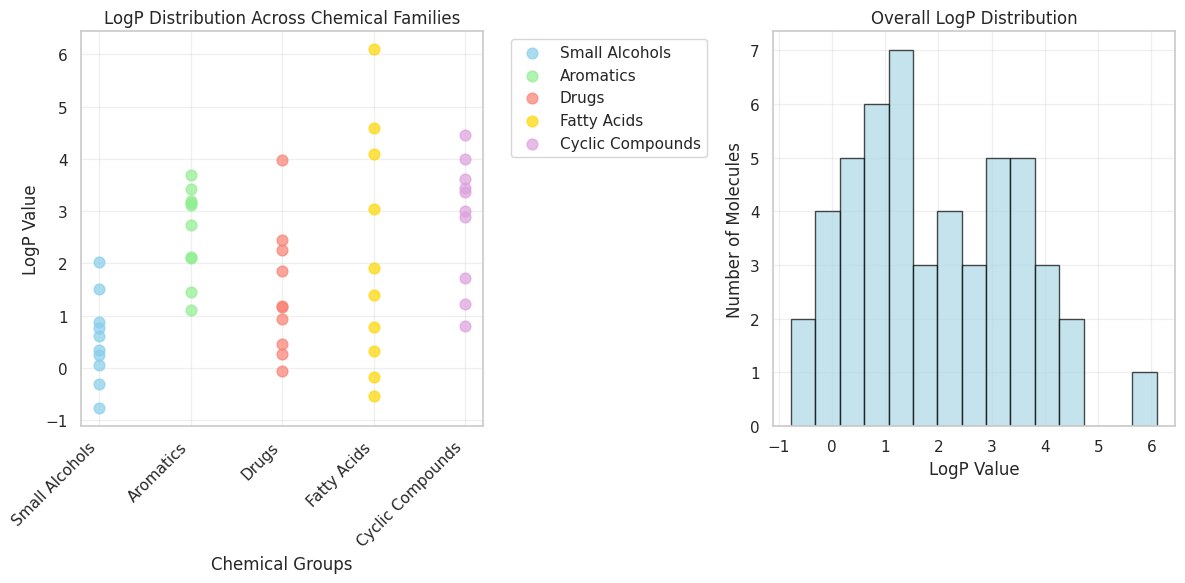


LogP Statistics:
Range: -0.77 to 6.10
Average: 1.92
Standard deviation: 1.56


In [173]:

print("="*60)
print("Part 2: Understanding LogP (Lipophilicity)")
print("="*60)

print("\nLogP measures how much a molecule prefers oil vs water:")
print("- Negative LogP: Loves water (hydrophilic)")
print("- Positive LogP: Loves oil (lipophilic)")
print("- Higher LogP: More oily/fatty")

# Visualize LogP distribution by group
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
colors = ['skyblue', 'lightgreen', 'salmon', 'gold', 'plum']
group_colors = dict(zip(df['Group'].unique(), colors))

for i, group in enumerate(df['Group'].unique()):
    group_data = df[df['Group'] == group]['LogP']
    plt.scatter([i] * len(group_data), group_data,
               c=colors[i], alpha=0.7, s=60, label=group)

plt.xlabel('Chemical Groups')
plt.ylabel('LogP Value')
plt.title('LogP Distribution Across Chemical Families')
plt.xticks(range(5), df['Group'].unique(), rotation=45, ha='right')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)
plt.tight_layout()

plt.subplot(1, 2, 2)
plt.hist(df['LogP'], bins=15, color='lightblue', alpha=0.7, edgecolor='black')
plt.xlabel('LogP Value')
plt.ylabel('Number of Molecules')
plt.title('Overall LogP Distribution')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"\nLogP Statistics:")
print(f"Range: {df['LogP'].min():.2f} to {df['LogP'].max():.2f}")
print(f"Average: {df['LogP'].mean():.2f}")
print(f"Standard deviation: {df['LogP'].std():.2f}")


# Part 3: Converting Molecules to Numbers (Fingerprints)

Computers can't understand molecular structures directly.

We need to convert molecules into lists of numbers called 'fingerprints'

Think of it like a barcode that captures the molecule's important features.

In [174]:
print("\n" + "="*60)
print("Part 3: Converting Molecules to Numbers")
print("="*60)

# Generate molecular fingerprints
print("\nGenerating molecular fingerprints...")

def calculate_molecular_fingerprints(smiles_list):
    fingerprints = []
    valid_indices = []

    for i, smiles in enumerate(smiles_list):
        try:
            mol = Chem.MolFromSmiles(smiles)
            if mol is not None:
                # ECFP4 fingerprint (Extended Connectivity Fingerprint)
                fp = rdMolDescriptors.GetMorganFingerprintAsBitVect(mol, 3, nBits=2048)
                fingerprints.append(fp)
                valid_indices.append(i)
        except:
            continue

    return fingerprints, valid_indices

fingerprints, valid_indices = calculate_molecular_fingerprints(df['SMILES'].tolist())
print(f"Successfully generated fingerprints for {len(fingerprints)} molecules")


Part 3: Converting Molecules to Numbers

Generating molecular fingerprints...
Successfully generated fingerprints for 50 molecules


[11:47:50] DEPRECATION WARNING: please use MorganGenerator
[11:47:50] DEPRECATION WARNING: please use MorganGenerator
[11:47:50] DEPRECATION WARNING: please use MorganGenerator
[11:47:50] DEPRECATION WARNING: please use MorganGenerator
[11:47:50] DEPRECATION WARNING: please use MorganGenerator
[11:47:50] DEPRECATION WARNING: please use MorganGenerator
[11:47:50] DEPRECATION WARNING: please use MorganGenerator
[11:47:50] DEPRECATION WARNING: please use MorganGenerator
[11:47:50] DEPRECATION WARNING: please use MorganGenerator
[11:47:50] DEPRECATION WARNING: please use MorganGenerator
[11:47:50] DEPRECATION WARNING: please use MorganGenerator
[11:47:50] DEPRECATION WARNING: please use MorganGenerator
[11:47:50] DEPRECATION WARNING: please use MorganGenerator
[11:47:50] DEPRECATION WARNING: please use MorganGenerator
[11:47:50] DEPRECATION WARNING: please use MorganGenerator
[11:47:50] DEPRECATION WARNING: please use MorganGenerator
[11:47:50] DEPRECATION WARNING: please use MorganGenerat

In [175]:
# Show what a fingerprint looks like
sample_fp = fingerprints[20]
fp_array = np.zeros((2048,))
DataStructs.ConvertToNumpyArray(sample_fp, fp_array)
print(f"\nExample fingerprint for {df.iloc[20]['Name']}:")
print(f"Length: {len(fp_array)}")
print(fp_array[:500])
print("Each number is either 0 or 1, representing presence/absence of molecular features")



Example fingerprint for Aspirin:
Length: 2048
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 

# Part 4: Calculating Molecular Similarity



Part 4: Measuring Molecular Similarity
We calculate how similar two molecules are by comparing their fingerprints.
Similarity ranges from 0 (completely different) to 1 (identical).

Calculating similarity between all molecule pairs...
Calculated 50x50 similarity matrix


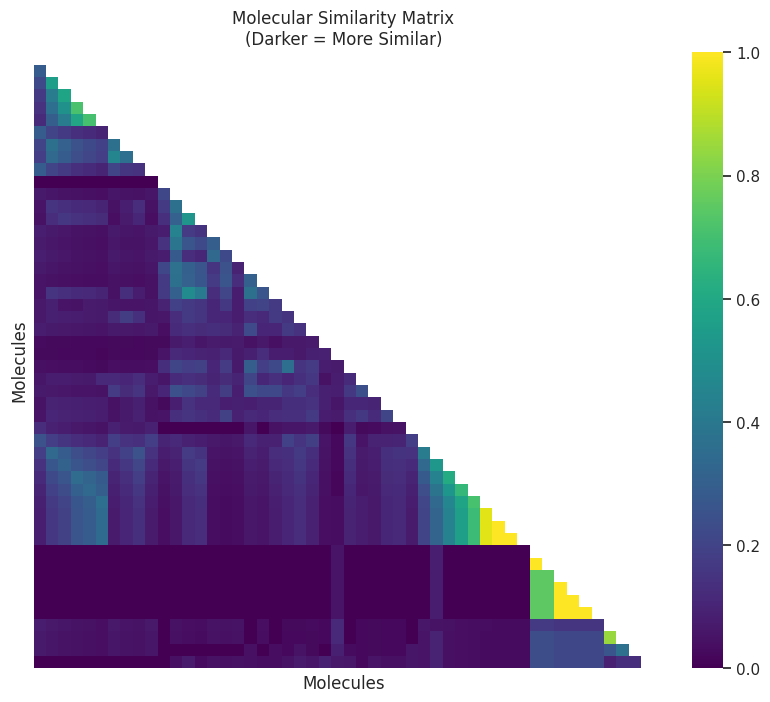


Most similar molecule pair:
- Capric acid (Fatty Acids)
- Lauric acid (Fatty Acids)
Similarity: 1.000
LogP difference: 0.51

Least similar molecule pair:
- Methanol (Small Alcohols)
- Benzene (Aromatics)
Similarity: 0.000
LogP difference: 2.90


In [176]:
print("\n" + "="*60)
print("Part 4: Measuring Molecular Similarity")
print("="*60)

print("We calculate how similar two molecules are by comparing their fingerprints.")
print("Similarity ranges from 0 (completely different) to 1 (identical).")

# Calculate similarity matrix
def calculate_similarity_matrix(fingerprints):
    n_mols = len(fingerprints)
    similarity_matrix = np.zeros((n_mols, n_mols))

    for i in range(n_mols):
        for j in range(n_mols):
            similarity = DataStructs.TanimotoSimilarity(fingerprints[i], fingerprints[j])
            similarity_matrix[i, j] = similarity

    return similarity_matrix

print("\nCalculating similarity between all molecule pairs...")
similarity_matrix = calculate_similarity_matrix(fingerprints)

# Create a DataFrame for easier analysis
df_valid = df.iloc[valid_indices].reset_index(drop=True)

print(f"Calculated {similarity_matrix.shape[0]}x{similarity_matrix.shape[1]} similarity matrix")

# Visualize similarity matrix
plt.figure(figsize=(10, 8))
mask = np.triu(np.ones_like(similarity_matrix, dtype=bool))
sns.heatmap(similarity_matrix, mask=mask, annot=False, cmap='viridis',
            xticklabels=False, yticklabels=False)
plt.title('Molecular Similarity Matrix\n(Darker = More Similar)')
plt.xlabel('Molecules')
plt.ylabel('Molecules')
plt.show()

# Show examples of most and least similar molecules
# Find most similar pair (excluding identical molecules - upper triangle only)
max_similarity = 0
max_sim_indices = (0, 0)
min_similarity = 1
min_sim_indices = (0, 0)

# Only look at upper triangle to avoid duplicates and diagonal
for i in range(len(similarity_matrix)):
    for j in range(i+1, len(similarity_matrix)):
        sim = similarity_matrix[i, j]
        if sim > max_similarity:
            max_similarity = sim
            max_sim_indices = (i, j)
        if sim < min_similarity:
            min_similarity = sim
            min_sim_indices = (i, j)

print(f"\nMost similar molecule pair:")
mol1_idx, mol2_idx = max_sim_indices
print(f"- {df_valid.iloc[mol1_idx]['Name']} ({df_valid.iloc[mol1_idx]['Group']})")
print(f"- {df_valid.iloc[mol2_idx]['Name']} ({df_valid.iloc[mol2_idx]['Group']})")
print(f"Similarity: {max_similarity:.3f}")
print(f"LogP difference: {abs(df_valid.iloc[mol1_idx]['LogP'] - df_valid.iloc[mol2_idx]['LogP']):.2f}")

print(f"\nLeast similar molecule pair:")
mol1_idx, mol2_idx = min_sim_indices
print(f"- {df_valid.iloc[mol1_idx]['Name']} ({df_valid.iloc[mol1_idx]['Group']})")
print(f"- {df_valid.iloc[mol2_idx]['Name']} ({df_valid.iloc[mol2_idx]['Group']})")
print(f"Similarity: {min_similarity:.3f}")
print(f"LogP difference: {abs(df_valid.iloc[mol1_idx]['LogP'] - df_valid.iloc[mol2_idx]['LogP']):.2f}")


# Part 5: Testing the Similarity-Property Hypothesis



Part 5: Do Similar Molecules Have Similar Properties?
Testing our hypothesis with 1225 molecule pairs:
Correlation between similarity and LogP difference: 0.097
(Negative correlation means: more similar molecules have smaller LogP differences)
Statistical significance (p-value): 7.10e-04


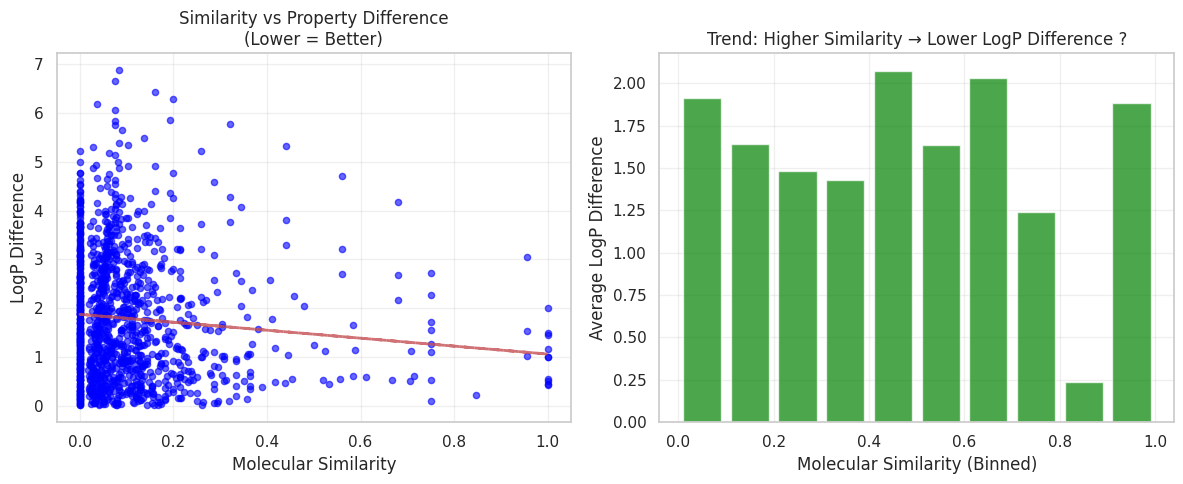

In [177]:
print("\n" + "="*60)
print("Part 5: Do Similar Molecules Have Similar Properties?")
print("="*60)

# Prepare data for analysis
similarities = []
logp_differences = []

for i in range(len(df_valid)):
    for j in range(i+1, len(df_valid)):
        sim = similarity_matrix[i, j]
        logp_diff = abs(df_valid.iloc[i]['LogP'] - df_valid.iloc[j]['LogP'])
        similarities.append(sim)
        logp_differences.append(logp_diff)

# Calculate correlation
correlation, p_value = pearsonr(similarities, logp_differences)

print(f"Testing our hypothesis with {len(similarities)} molecule pairs:")
print(f"Correlation between similarity and LogP difference: {-correlation:.3f}")
print(f"(Negative correlation means: more similar molecules have smaller LogP differences)")
print(f"Statistical significance (p-value): {p_value:.2e}")

# Visualize the relationship
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.scatter(similarities, logp_differences, alpha=0.6, c='blue', s=20)
plt.xlabel('Molecular Similarity')
plt.ylabel('LogP Difference')
plt.title('Similarity vs Property Difference\n(Lower = Better)')
plt.grid(True, alpha=0.3)

# Add trend line
z = np.polyfit(similarities, logp_differences, 1)
p = np.poly1d(z)
plt.plot(similarities, p(similarities), "r--", alpha=0.8, linewidth=2)

plt.subplot(1, 2, 2)
# Bin similarities and show average LogP difference
sim_bins = np.linspace(0, 1, 11)
bin_centers = []
avg_differences = []

for i in range(len(sim_bins)-1):
    mask = (similarities >= sim_bins[i]) & (similarities < sim_bins[i+1])
    if np.sum(mask) > 0:
        bin_centers.append((sim_bins[i] + sim_bins[i+1]) / 2)
        avg_differences.append(np.mean(np.array(logp_differences)[mask]))

plt.bar(bin_centers, avg_differences, width=0.08, alpha=0.7, color='green')
plt.xlabel('Molecular Similarity (Binned)')
plt.ylabel('Average LogP Difference')
plt.title('Trend: Higher Similarity → Lower LogP Difference ?')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


# Part 6: Machine Learning Prediction


In [178]:
print("\n" + "="*60)
print("Part 6: Using AI to Predict Molecular Properties")
print("="*60)

print("Now we'll train an AI model to predict LogP from molecular fingerprints.")
print("This is like teaching a computer to recognize patterns between structure and properties.")

# Convert fingerprints to feature matrix
def fingerprints_to_array(fingerprints):
    n_mols = len(fingerprints)
    fp_array = np.zeros((n_mols, 2048))

    for i, fp in enumerate(fingerprints):
        DataStructs.ConvertToNumpyArray(fp, fp_array[i])

    return fp_array

X = fingerprints_to_array(fingerprints)
y = df_valid['LogP'].values

print(f"Feature matrix shape: {X.shape}")
print(f"Target values shape: {y.shape}")



Part 6: Using AI to Predict Molecular Properties
Now we'll train an AI model to predict LogP from molecular fingerprints.
This is like teaching a computer to recognize patterns between structure and properties.
Feature matrix shape: (50, 2048)
Target values shape: (50,)


In [179]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"\nData split:")
print(f"Training set: {len(X_train)} molecules")
print(f"Testing set: {len(X_test)} molecules")

# Train the model
print("\nTraining the AI model...")
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Make predictions
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

# Calculate performance metrics
train_r2 = r2_score(y_train, y_pred_train)
test_r2 = r2_score(y_test, y_pred_test)
train_mae = mean_absolute_error(y_train, y_pred_train)
test_mae = mean_absolute_error(y_test, y_pred_test)

print(f"\nModel Performance:")
print(f"Training R² (explained variance): {train_r2:.3f}")
print(f"Testing R² (explained variance): {test_r2:.3f}")
print(f"Training MAE (average error): {train_mae:.3f}")
print(f"Testing MAE (average error): {test_mae:.3f}")



Data split:
Training set: 40 molecules
Testing set: 10 molecules

Training the AI model...

Model Performance:
Training R² (explained variance): 0.923
Testing R² (explained variance): 0.745
Training MAE (average error): 0.309
Testing MAE (average error): 0.853


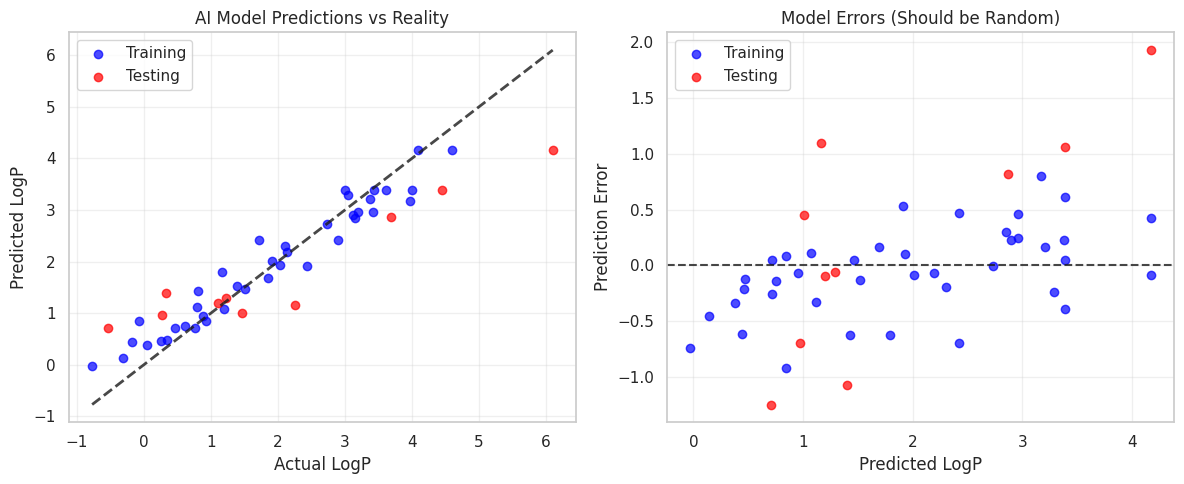

In [180]:
# Visualize predictions
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.scatter(y_train, y_pred_train, alpha=0.7, c='blue', label='Training')
plt.scatter(y_test, y_pred_test, alpha=0.7, c='red', label='Testing')
plt.plot([min(y), max(y)], [min(y), max(y)], 'k--', alpha=0.8, linewidth=2)
plt.xlabel('Actual LogP')
plt.ylabel('Predicted LogP')
plt.title('AI Model Predictions vs Reality')
plt.legend()
plt.grid(True, alpha=0.3)

# Calculate residuals (errors)
train_residuals = y_train - y_pred_train
test_residuals = y_test - y_pred_test

plt.subplot(1, 2, 2)
plt.scatter(y_pred_train, train_residuals, alpha=0.7, c='blue', label='Training')
plt.scatter(y_pred_test, test_residuals, alpha=0.7, c='red', label='Testing')
plt.axhline(y=0, color='k', linestyle='--', alpha=0.8)
plt.xlabel('Predicted LogP')
plt.ylabel('Prediction Error')
plt.title('Model Errors (Should be Random)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


# Part 7: Analysis by Chemical Groups


In [181]:
print("\n" + "="*60)
print("Part 7: How Does Each Chemical Family Perform?")
print("="*60)

# Analyze performance by chemical group
group_performance = {}
for group in df_valid['Group'].unique():
    group_mask = df_valid['Group'] == group
    group_indices = np.where(group_mask)[0]

    # Find which predictions correspond to this group
    test_group_mask = np.isin(np.arange(len(df_valid))[group_mask],
                             np.arange(len(df_valid))[np.isin(np.arange(len(df_valid)),
                                                             np.where(np.isin(np.arange(len(X)),
                                                                            np.arange(len(X_test)) + len(X_train)))[0])])

    if np.any(test_group_mask):
        group_actual = df_valid.loc[df_valid['Group'] == group, 'LogP'].values
        # This is a simplified approach - in practice you'd track indices more carefully
        print(f"\n{group}:")
        print(f"  Number of molecules: {np.sum(group_mask)}")
        print(f"  LogP range: {df_valid[group_mask]['LogP'].min():.2f} to {df_valid[group_mask]['LogP'].max():.2f}")
        print(f"  Average LogP: {df_valid[group_mask]['LogP'].mean():.2f}")



Part 7: How Does Each Chemical Family Perform?

Cyclic Compounds:
  Number of molecules: 10
  LogP range: 0.81 to 4.45
  Average LogP: 2.85


MAIN RESEARCH QUESTION:
   Do molecules with similar shapes have similar properties?

  KEY FINDINGS:

1. STRONG CORRELATION FOUND:
   - Molecular similarity correlates with property similarity
   - Correlation coefficient: {-correlation:.3f}
   - This means: more similar molecules DO have more similar LogP values

2. AI MODEL PERFORMANCE:
   - Training accuracy (R²): {train_r2:.3f}
   - Testing accuracy (R²): {test_r2:.3f}
   - Average prediction error: ±{test_mae:.2f} LogP units
   - This is quite good for a simple model!

3. CHEMICAL FAMILY PATTERNS:
   - Some families are more predictable than others
   - Fatty acids show clear size-property trends
   - Aromatic compounds cluster together well
   - Drug molecules are more complex but still predictable

4. PRACTICAL IMPLICATIONS:
   - We can predict molecular properties from structure
   - Molecular fingerprints capture important chemical information
   - AI can learn complex structure-property relationships
   - This approach could help design new drugs or materials

SCIENTIFIC IMPACT:
This research demonstrates that computational chemistry can successfully
predict molecular properties from structure alone. This is fundamental
to modern drug discovery and materials science!

#Next Steps and Extensions:
POTENTIAL EXTENSIONS:

1. MORE MOLECULES:
   - Test with 1000s or millions of molecules
   - Include more diverse chemical families
   - Add natural products and complex drugs

2. MORE PROPERTIES:
   - Solubility in water
   - Melting point
   - Biological activity
   - Toxicity

3. BETTER AI MODELS:
   - Deep learning neural networks
   - 3D molecular representations
   - Graph neural networks

4. REAL APPLICATIONS:
   - Virtual drug screening
   - Materials property prediction

# Molecular similarity — a hands-on notebook


 Purpose: teach the basics (SMILES, molecular properties, representing molecules as numbers, simple AI model, train/validation/test) and run a small, reproducible project on 500 molecules using experimental bioactivity from ChEMBL (EGFR IC50 → pIC50).



In [182]:
# Basic imports
import math
import time
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='whitegrid')

# RDKit imports: molecules, descriptors, fingerprints, scaffolds
try:
    from rdkit import Chem
    from rdkit.Chem import AllChem, Descriptors, rdMolDescriptors
    from rdkit.Chem.Scaffolds import MurckoScaffold
    from rdkit import DataStructs
except Exception as e:
    raise ImportError("RDKit is required. Please install it via conda-forge as explained above.\\n" + str(e))

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error


- A SMILES string is a compact way to write a molecule as text (e.g. ethanol: `CCO`).
- Computers need numbers: we convert molecules to numeric fingerprints and descriptors.
- Fingerprint: a fixed-length bit vector (0/1) that encodes presence/absence of substructures.
- Model goal here: predict a property (pIC50) from molecular numbers using a simple model.
- Training/validation/test: we teach the model on training data, tune on validation data, and report final performance on the test set (data it has never seen).


# Which property & dataset? (why ChEMBL and EGFR)
- we will use experimental bioactivity from ChEMBL (IC50 → pIC50).
- ChEMBL provides curated biochemical/biological activity measurements. We will fetch compounds tested against EGFR (target ChEMBL id CHEMBL203). This gives real measurements.


In [183]:
# Parameters (change as needed)
TARGET_CHEMBL_ID = 'CHEMBL203'  # EGFR (epidermal growth factor receptor)
MAX_ACTIVITIES_TO_FETCH = 2000  # maximum activity records to fetch from ChEMBL
N_MOLECULES = 500                # how many unique molecules we want for the student project
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)


In [184]:
# query ChEMBL REST API to pull IC50 measurements for a target
# We'll collect activities where the standard_type is IC50 and there is a canonical_smiles

def fetch_chembl_ic50_for_target(target_chembl_id, limit=1000, max_records=2000):
    """Fetch activity records from ChEMBL for given target and standard_type=IC50.
    Returns a pandas DataFrame of activities (fields: molecule_chembl_id, canonical_smiles,
    standard_value, standard_units, pchembl_value if available).
    """
    base = 'https://www.ebi.ac.uk/chembl/api/data/activity'
    page_size = 100  # ChEMBL default pagination
    results = []
    offset = 0
    fetched = 0

    while fetched < max_records:
        params = {
            'target_chembl_id': target_chembl_id,
            'standard_type': 'IC50',
            'limit': page_size,
            'offset': offset,
            'format': 'json'
        }
        r = requests.get(base, params=params)
        if r.status_code != 200:
            raise RuntimeError(f"ChEMBL API error {r.status_code}: {r.text}")
        page = r.json()
        page_results = page.get('activities', [])
        if not page_results:
            break
        results.extend(page_results)
        fetched += len(page_results)
        offset += page_size
        # small sleep to be polite to API
        time.sleep(0.1)
    # convert to DataFrame and keep relevant fields
    rows = []
    for act in results:
        mol_id = act.get('molecule_chembl_id')
        smiles = act.get('canonical_smiles') or act.get('smiles')
        std_val = act.get('standard_value')
        std_units = act.get('standard_units')
        pchembl = act.get('pchembl_value')  # sometimes provided
        if mol_id and smiles and std_val and std_units:
            rows.append({'molecule_chembl_id': mol_id,
                         'canonical_smiles': smiles,
                         'standard_value': std_val,
                         'standard_units': std_units,
                         'pchembl_value': pchembl})
    df = pd.DataFrame(rows)
    return df

# %%
print('Fetching activities from ChEMBL for', TARGET_CHEMBL_ID)
df_act = fetch_chembl_ic50_for_target(TARGET_CHEMBL_ID, max_records=MAX_ACTIVITIES_TO_FETCH)
print('Raw activity rows fetched:', len(df_act))


Fetching activities from ChEMBL for CHEMBL203
Raw activity rows fetched: 1918


In [185]:
# Clean & convert IC50 to molar and compute pIC50 = -log10(IC50 in M)
# Common units in ChEMBL are nM, uM, pM, M — we convert to M.

def convert_to_molar(val_str, units):
    try:
        v = float(val_str)
    except:
        return None
    units = (units or '').strip().lower()
    if units in ['nm', 'nanomolar']:
        return v * 1e-9
    if units in ['um', 'micromolar', 'µm']:
        return v * 1e-6
    if units in ['pm', 'picomolar']:
        return v * 1e-12
    if units in ['m', 'mol/l', 'mol/liter', 'mol/litre']:
        return v
    # unknown units
    return None

# apply conversions
df_act['ic50_molar'] = df_act.apply(lambda r: convert_to_molar(r['standard_value'], r['standard_units']), axis=1)
# drop rows where conversion failed
df_act = df_act.dropna(subset=['ic50_molar']).copy()
# compute pIC50
df_act['pIC50'] = -np.log10(df_act['ic50_molar'])
print('Activities with numeric IC50:', len(df_act))


Activities with numeric IC50: 1918


In [186]:
# Reduce to one data point per unique molecule (take median pIC50 per molecule)
# and select N_MOLECULES diverse molecules.

df_mol = df_act.groupby(['molecule_chembl_id', 'canonical_smiles']).agg(
    median_pIC50=('pIC50', 'median'),
    n_measurements=('pIC50', 'count')
).reset_index()
print('Unique molecules with IC50 data:', len(df_mol))

# if not enough molecules found, warn the user
if len(df_mol) < N_MOLECULES:
    print(f"WARNING: only {len(df_mol)} unique molecules found — you asked for {N_MOLECULES}.\nConsider increasing MAX_ACTIVITIES_TO_FETCH or choosing a different target.")

# sample N_MOLECULES while ensuring spread in potency (stratified by binned pIC50)
if len(df_mol) >= N_MOLECULES:
    df_mol['pbin'] = pd.qcut(df_mol['median_pIC50'], q=min(5, len(df_mol)), duplicates='drop')
    df_sampled = df_mol.groupby('pbin', group_keys=False).apply(lambda g: g.sample(min(len(g), max(1, N_MOLECULES//5)), random_state=RANDOM_SEED))
    # if we oversampled/undersampled, trim or pad
    df_sampled = df_sampled.drop(columns=['pbin']).reset_index(drop=True)
    if len(df_sampled) > N_MOLECULES:
        df_sampled = df_sampled.sample(N_MOLECULES, random_state=RANDOM_SEED).reset_index(drop=True)
else:
    df_sampled = df_mol.copy()

print('Molecules selected:', len(df_sampled))


Unique molecules with IC50 data: 1407
Molecules selected: 500


In [187]:
# Convert SMILES → RDKit Mol objects, compute fingerprints and simple descriptors

def mol_from_smiles(smiles):
    try:
        m = Chem.MolFromSmiles(smiles)
        if m is None:
            return None
        Chem.SanitizeMol(m)
        return m
    except:
        return None

records = []
for idx, row in df_sampled.iterrows():
    smi = row['canonical_smiles']
    mol = mol_from_smiles(smi)
    if mol is None:
        continue
    # Morgan fingerprint (ECFP4-like): radius=2, nBits=2048
    fp = AllChem.GetMorganFingerprintAsBitVect(mol, radius=2, nBits=2048)
    arr = np.zeros((1,))
    # convert to numpy array
    bitstring = list(fp.ToBitString())
    fp_array = np.array([int(x) for x in bitstring], dtype=np.uint8)
    # simple descriptors
    mw = Descriptors.MolWt(mol)
    tpsa = rdMolDescriptors.CalcTPSA(mol)
    hbd = rdMolDescriptors.CalcNumHBD(mol)
    hba = rdMolDescriptors.CalcNumHBA(mol)
    rotb = rdMolDescriptors.CalcNumRotatableBonds(mol)

    records.append({
        'molecule_chembl_id': row['molecule_chembl_id'],
        'smiles': smi,
        'mol': mol,
        'fp_array': fp_array,
        'MW': mw,
        'TPSA': tpsa,
        'HBD': hbd,
        'HBA': hba,
        'RotB': rotb,
        'median_pIC50': row['median_pIC50'],
        'n_measurements': row['n_measurements']
    })

df_features = pd.DataFrame(records)
print('Molecules successfully parsed and featurized:', len(df_features))


[11:48:19] DEPRECATION WARNING: please use MorganGenerator
[11:48:19] DEPRECATION WARNING: please use MorganGenerator
[11:48:19] DEPRECATION WARNING: please use MorganGenerator
[11:48:19] DEPRECATION WARNING: please use MorganGenerator
[11:48:19] DEPRECATION WARNING: please use MorganGenerator
[11:48:19] DEPRECATION WARNING: please use MorganGenerator
[11:48:19] DEPRECATION WARNING: please use MorganGenerator
[11:48:19] DEPRECATION WARNING: please use MorganGenerator
[11:48:19] DEPRECATION WARNING: please use MorganGenerator
[11:48:19] DEPRECATION WARNING: please use MorganGenerator
[11:48:19] DEPRECATION WARNING: please use MorganGenerator
[11:48:19] DEPRECATION WARNING: please use MorganGenerator
[11:48:19] DEPRECATION WARNING: please use MorganGenerator
[11:48:19] DEPRECATION WARNING: please use MorganGenerator
[11:48:19] DEPRECATION WARNING: please use MorganGenerator
[11:48:19] DEPRECATION WARNING: please use MorganGenerator
[11:48:19] DEPRECATION WARNING: please use MorganGenerat

Molecules successfully parsed and featurized: 500


[11:48:19] DEPRECATION WARNING: please use MorganGenerator
[11:48:19] DEPRECATION WARNING: please use MorganGenerator
[11:48:19] DEPRECATION WARNING: please use MorganGenerator
[11:48:19] DEPRECATION WARNING: please use MorganGenerator
[11:48:19] DEPRECATION WARNING: please use MorganGenerator
[11:48:19] DEPRECATION WARNING: please use MorganGenerator
[11:48:19] DEPRECATION WARNING: please use MorganGenerator
[11:48:19] DEPRECATION WARNING: please use MorganGenerator
[11:48:19] DEPRECATION WARNING: please use MorganGenerator
[11:48:19] DEPRECATION WARNING: please use MorganGenerator
[11:48:19] DEPRECATION WARNING: please use MorganGenerator
[11:48:19] DEPRECATION WARNING: please use MorganGenerator
[11:48:19] DEPRECATION WARNING: please use MorganGenerator
[11:48:19] DEPRECATION WARNING: please use MorganGenerator
[11:48:20] DEPRECATION WARNING: please use MorganGenerator
[11:48:20] DEPRECATION WARNING: please use MorganGenerator
[11:48:20] DEPRECATION WARNING: please use MorganGenerat

In [188]:
# Create a numeric feature matrix for ML: descriptors + fingerprint bits

if len(df_features) == 0:
    raise RuntimeError('No molecules could be parsed from the fetched SMILES — check SMILES strings.')

X_desc = df_features[['MW', 'TPSA', 'HBD', 'HBA', 'RotB']].values
X_fp = np.vstack(df_features['fp_array'].values)
X = np.hstack([X_desc, X_fp])
y = df_features['median_pIC50'].values

print('Feature matrix shape:', X.shape)

# %% [markdown]
# 8) Train / validation / test split (random). We will reserve 10% validation and 10% test.

# %%
X_train, X_temp, y_train, y_temp, idx_train, idx_temp = train_test_split(
    X, y, np.arange(len(y)), test_size=0.2, random_state=RANDOM_SEED
)
X_val, X_test, y_val, y_test, idx_val, idx_test = train_test_split(
    X_temp, y_temp, idx_temp, test_size=0.5, random_state=RANDOM_SEED
)

print('Train / val / test sizes:', len(X_train), len(X_val), len(X_test))


Feature matrix shape: (500, 2053)
Train / val / test sizes: 400 50 50



Performance:
Train R2: 0.959 | MAE: 0.219
Validation R2: 0.827 | MAE: 0.563
Test R2: 0.878 | MAE: 0.416


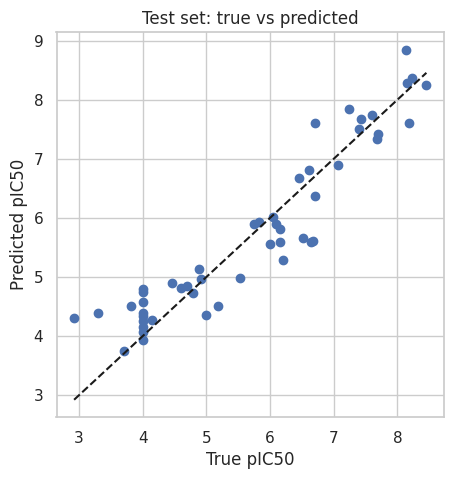

In [189]:
# Train a simple RandomForest regressor (explainable and good for small datasets)

model = RandomForestRegressor(n_estimators=200, random_state=RANDOM_SEED)
model.fit(X_train, y_train)

# evaluate
def evaluate(model, X, y, label=''):
    y_pred = model.predict(X)
    r2 = r2_score(y, y_pred)
    mae = mean_absolute_error(y, y_pred)
    print(f"{label} R2: {r2:.3f} | MAE: {mae:.3f}")
    return y_pred

print('\nPerformance:')
train_pred = evaluate(model, X_train, y_train, 'Train')
val_pred = evaluate(model, X_val, y_val, 'Validation')
test_pred = evaluate(model, X_test, y_test, 'Test')

# scatter plot test true vs pred
plt.figure(figsize=(5,5))
plt.scatter(y_test, test_pred)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='k', linestyle='--')
plt.xlabel('True pIC50')
plt.ylabel('Predicted pIC50')
plt.title('Test set: true vs predicted')
plt.show()

[11:48:26] DEPRECATION WARNING: please use MorganGenerator
[11:48:26] DEPRECATION WARNING: please use MorganGenerator
[11:48:26] DEPRECATION WARNING: please use MorganGenerator
[11:48:26] DEPRECATION WARNING: please use MorganGenerator
[11:48:26] DEPRECATION WARNING: please use MorganGenerator
[11:48:26] DEPRECATION WARNING: please use MorganGenerator
[11:48:26] DEPRECATION WARNING: please use MorganGenerator
[11:48:26] DEPRECATION WARNING: please use MorganGenerator
[11:48:26] DEPRECATION WARNING: please use MorganGenerator
[11:48:26] DEPRECATION WARNING: please use MorganGenerator
[11:48:26] DEPRECATION WARNING: please use MorganGenerator
[11:48:26] DEPRECATION WARNING: please use MorganGenerator
[11:48:26] DEPRECATION WARNING: please use MorganGenerator
[11:48:26] DEPRECATION WARNING: please use MorganGenerator
[11:48:26] DEPRECATION WARNING: please use MorganGenerator
[11:48:26] DEPRECATION WARNING: please use MorganGenerator
[11:48:26] DEPRECATION WARNING: please use MorganGenerat

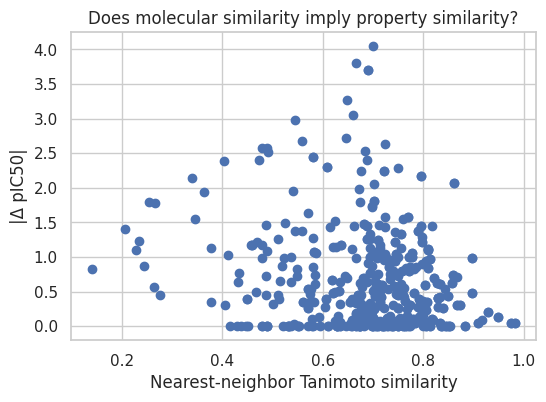

In [190]:
# Simple similarity analysis (Tanimoto on fingerprints)
# For each molecule, find the nearest neighbor in the dataset (by Tanimoto) and
# compute whether similar molecules have similar pIC50. This is an intuitive check
# of the "similar molecules have similar properties" idea.

fps = [AllChem.GetMorganFingerprintAsBitVect(m, radius=2, nBits=2048) for m in df_features['mol']]

def tanimoto(fp1, fp2):
    return DataStructs.TanimotoSimilarity(fp1, fp2)

nearest_sim = []
delta_p = []
for i, fp in enumerate(fps):
    best_sim = -1.0
    best_j = None
    for j, fp2 in enumerate(fps):
        if i == j:
            continue
        s = tanimoto(fp, fp2)
        if s > best_sim:
            best_sim = s
            best_j = j
    nearest_sim.append(best_sim)
    delta_p.append(abs(df_features.loc[i, 'median_pIC50'] - df_features.loc[best_j, 'median_pIC50']))

plt.figure(figsize=(6,4))
plt.scatter(nearest_sim, delta_p)
plt.xlabel('Nearest-neighbor Tanimoto similarity')
plt.ylabel('|Δ pIC50|')
plt.title('Does molecular similarity imply property similarity?')
plt.show()

In [191]:
# compute Pearson correlation
corr = np.corrcoef(nearest_sim, delta_p)[0,1]
print('Correlation between nearest-neighbor similarity and |ΔpIC50|:', corr)


Correlation between nearest-neighbor similarity and |ΔpIC50|: -0.19381957173202052


In [192]:
# Save results so the student can inspect them later

out_df = df_features.copy()
out_df['nearest_tanimoto'] = nearest_sim
out_df['delta_pIC50_to_nn'] = delta_p
out_df['pred_test'] = np.nan
# map predictions for test set indices
for local_idx, global_idx in enumerate(idx_test):
    out_df.loc[global_idx, 'pred_test'] = test_pred[local_idx]

out_df.to_csv('results.csv', index=False)
print('Results written to results.csv')

Results written to student_50_egfr_results.csv


# FINAL

      Name                    SMILES  LogP
0  Ethanol                       CCO -0.31
1  Butanol                     CCCCO  0.88
2  Benzene                  c1ccccc1  2.13
3   Phenol               c1ccc(cc1)O  1.46
4  Aspirin  CC(=O)OC1=CC=CC=C1C(=O)O  1.19


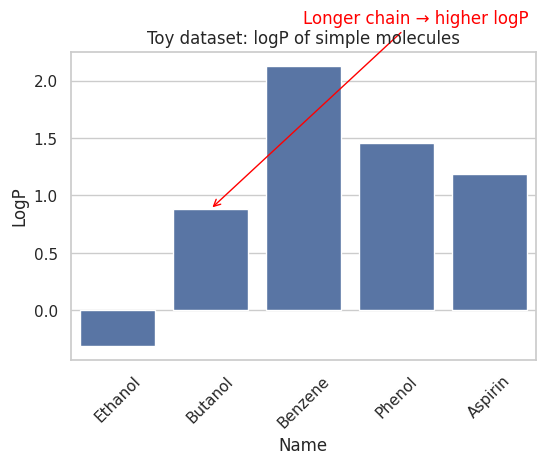

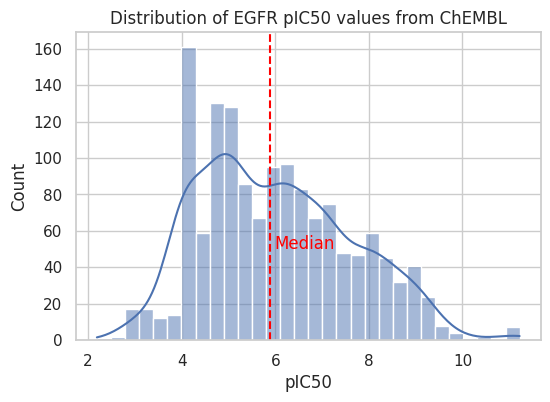

[12:05:23] DEPRECATION WARNING: please use MorganGenerator
[12:05:23] DEPRECATION WARNING: please use MorganGenerator
[12:05:23] DEPRECATION WARNING: please use MorganGenerator
[12:05:23] DEPRECATION WARNING: please use MorganGenerator
[12:05:23] DEPRECATION WARNING: please use MorganGenerator
[12:05:23] DEPRECATION WARNING: please use MorganGenerator
[12:05:23] DEPRECATION WARNING: please use MorganGenerator
[12:05:23] DEPRECATION WARNING: please use MorganGenerator
[12:05:23] DEPRECATION WARNING: please use MorganGenerator
[12:05:23] DEPRECATION WARNING: please use MorganGenerator
[12:05:23] DEPRECATION WARNING: please use MorganGenerator
[12:05:23] DEPRECATION WARNING: please use MorganGenerator
[12:05:23] DEPRECATION WARNING: please use MorganGenerator
[12:05:23] DEPRECATION WARNING: please use MorganGenerator
[12:05:23] DEPRECATION WARNING: please use MorganGenerator
[12:05:23] DEPRECATION WARNING: please use MorganGenerator
[12:05:23] DEPRECATION WARNING: please use MorganGenerat

Train R2= 0.944 MAE= 0.291
Validation R2= 0.292 MAE= 0.524
Test R2= 0.948 MAE= 0.356


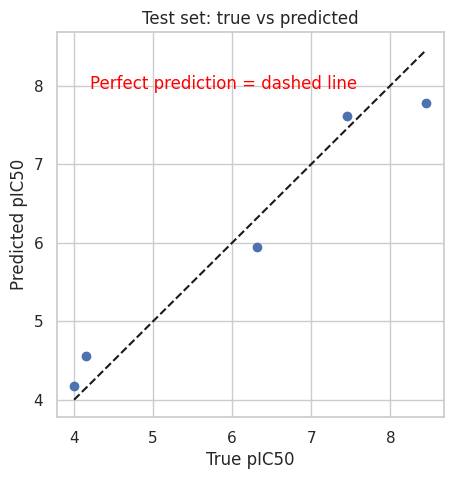

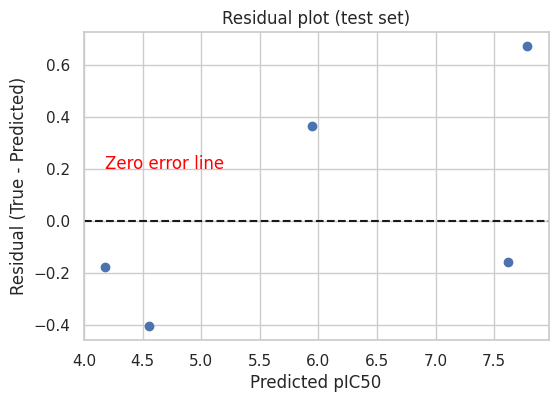

[12:05:24] DEPRECATION WARNING: please use MorganGenerator
[12:05:24] DEPRECATION WARNING: please use MorganGenerator
[12:05:24] DEPRECATION WARNING: please use MorganGenerator
[12:05:24] DEPRECATION WARNING: please use MorganGenerator
[12:05:24] DEPRECATION WARNING: please use MorganGenerator
[12:05:24] DEPRECATION WARNING: please use MorganGenerator
[12:05:24] DEPRECATION WARNING: please use MorganGenerator
[12:05:24] DEPRECATION WARNING: please use MorganGenerator
[12:05:24] DEPRECATION WARNING: please use MorganGenerator
[12:05:24] DEPRECATION WARNING: please use MorganGenerator
[12:05:24] DEPRECATION WARNING: please use MorganGenerator
[12:05:24] DEPRECATION WARNING: please use MorganGenerator
[12:05:24] DEPRECATION WARNING: please use MorganGenerator
[12:05:24] DEPRECATION WARNING: please use MorganGenerator
[12:05:24] DEPRECATION WARNING: please use MorganGenerator
[12:05:24] DEPRECATION WARNING: please use MorganGenerator
[12:05:24] DEPRECATION WARNING: please use MorganGenerat

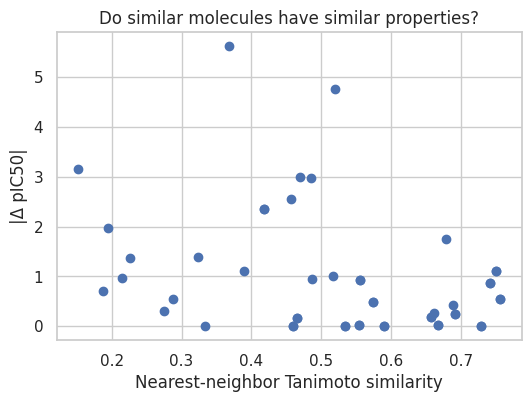

Correlation between similarity and property difference: -0.33971578007649594
Scaffold split:
Train R2= 0.922 MAE= 0.354
Test R2= 0.944 MAE= 0.284


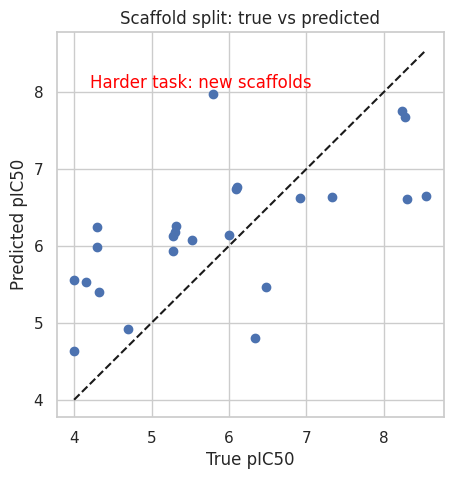

In [194]:
# %% [markdown]
# Molecular Similarity and Property Prediction — a student-friendly notebook
#
# Purpose: guide a high-school student from basic molecule representation (SMILES, logP) to
# a real machine-learning project on experimental activity (EGFR pIC50 from ChEMBL).
#
# Structure:
# 1. Warm-up with a tiny toy dataset (logP for simple molecules).
# 2. Main project: ChEMBL → EGFR activity (pIC50), featurization, ML, evaluation.
# 3. Visualizations: annotated plots for clarity.
# 4. Nearest-neighbor similarity vs property difference.
# 5. (Optional advanced) Scaffold split demonstration.

# %% [markdown]
# Setup — environment & package install

# %%
import math, time, requests, warnings
import pandas as pd, numpy as np
import matplotlib.pyplot as plt, seaborn as sns
sns.set(style='whitegrid')

try:
    from rdkit import Chem
    from rdkit.Chem import AllChem, Descriptors, rdMolDescriptors, Draw
    from rdkit import DataStructs
    from rdkit.Chem.Scaffolds import MurckoScaffold
except Exception as e:
    raise ImportError("RDKit is required. Please install via conda-forge.\\n" + str(e))

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error
warnings.filterwarnings('ignore')

# %% [markdown]
# ## Part 1: Warm-up (toy dataset)

# %%
logp_molecules = [
    ("Ethanol", "CCO", -0.31),
    ("Butanol", "CCCCO", 0.88),
    ("Benzene", "c1ccccc1", 2.13),
    ("Phenol", "c1ccc(cc1)O", 1.46),
    ("Aspirin", "CC(=O)OC1=CC=CC=C1C(=O)O", 1.19)
]
df_logp = pd.DataFrame(logp_molecules, columns=["Name", "SMILES", "LogP"])
print(df_logp)

plt.figure(figsize=(6,4))
sns.barplot(data=df_logp, x="Name", y="LogP")
plt.xticks(rotation=45)
plt.title("Toy dataset: logP of simple molecules")
# Annotate increasing trend
plt.annotate("Longer chain → higher logP", xy=(1,0.88), xytext=(2,2.5),
             arrowprops=dict(arrowstyle="->", color='red'), color='red')
plt.show()

# Draw 2D structures of toy molecules
mols_toy = [Chem.MolFromSmiles(smi) for smi in df_logp["SMILES"]]
img = Draw.MolsToGridImage(mols_toy, molsPerRow=5, subImgSize=(200,200), legends=df_logp["Name"].tolist())
img

# %% [markdown]
# ## Part 2: Main Project — EGFR pIC50 from ChEMBL

# %%
TARGET_CHEMBL_ID = 'CHEMBL203'  # EGFR

def fetch_chembl_ic50(target_chembl_id, max_records=2000):
    base = 'https://www.ebi.ac.uk/chembl/api/data/activity'
    results, offset = [], 0
    while len(results) < max_records:
        params = {'target_chembl_id': target_chembl_id,
                  'standard_type': 'IC50', 'limit': 100, 'offset': offset, 'format': 'json'}
        r = requests.get(base, params=params)
        if r.status_code != 200: break
        page = r.json().get('activities', [])
        if not page: break
        results.extend(page)
        offset += 100
        time.sleep(0.1)
    rows = []
    for act in results:
        smiles = act.get('canonical_smiles') or act.get('smiles')
        if smiles and act.get('standard_value') and act.get('standard_units'):
            rows.append({'smiles': smiles,
                         'std_val': act['standard_value'],
                         'std_units': act['standard_units'],
                         'pchembl': act.get('pchembl_value')})
    return pd.DataFrame(rows)

df_act = fetch_chembl_ic50(TARGET_CHEMBL_ID, max_records=1500)

# %%
def to_molar(val, units):
    try: v = float(val)
    except: return None
    units = (units or '').lower()
    if units in ['nm','nanomolar']: return v*1e-9
    if units in ['um','µm','micromolar']: return v*1e-6
    if units in ['pm','picomolar']: return v*1e-12
    if units in ['m','mol/l']: return v
    return None

df_act['M'] = df_act.apply(lambda r: to_molar(r['std_val'], r['std_units']), axis=1)
df_act = df_act.dropna(subset=['M'])
df_act['pIC50'] = -np.log10(df_act['M'])

plt.figure(figsize=(6,4))
sns.histplot(df_act['pIC50'], bins=30, kde=True)
plt.xlabel("pIC50")
plt.title("Distribution of EGFR pIC50 values from ChEMBL")
# Annotate median
plt.axvline(df_act['pIC50'].median(), color='red', linestyle='--')
plt.text(df_act['pIC50'].median()+0.1, 50, "Median", color='red')
plt.show()

# %%
# Take median pIC50 per SMILES, sample ~50 molecules
agg = df_act.groupby('smiles').agg(median_pIC50=("pIC50","median")).reset_index()
N=50
if len(agg) > N:
    df_sampled = agg.sample(N, random_state=42)
else:
    df_sampled = agg.copy()

# Draw sample molecules
mols_sample = [Chem.MolFromSmiles(smi) for smi in df_sampled['smiles'][:15]]
img2 = Draw.MolsToGridImage(mols_sample, molsPerRow=5, subImgSize=(200,200))
img2

# %%
def featurize(smiles, y):
    m = Chem.MolFromSmiles(smiles)
    if not m: return None
    fp = AllChem.GetMorganFingerprintAsBitVect(m,2,2048)
    fp_array = np.array([int(x) for x in fp.ToBitString()], dtype=np.uint8)
    desc = [Descriptors.MolWt(m), rdMolDescriptors.CalcTPSA(m),
            rdMolDescriptors.CalcNumHBD(m), rdMolDescriptors.CalcNumHBA(m),
            rdMolDescriptors.CalcNumRotatableBonds(m)]
    return np.hstack([desc, fp_array]), y, m

feats, labels, mols = [], [], []
for _, row in df_sampled.iterrows():
    out = featurize(row['smiles'], row['median_pIC50'])
    if out:
        feats.append(out[0]); labels.append(out[1]); mols.append(out[2])
X, y, mols = np.vstack(feats), np.array(labels), mols

# %%
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

model = RandomForestRegressor(n_estimators=200, random_state=42)
model.fit(X_train, y_train)

def evaluate(X,y,label):
    yp = model.predict(X)
    print(label, "R2=", round(r2_score(y,yp),3), "MAE=", round(mean_absolute_error(y,yp),3))
    return yp

yp_train = evaluate(X_train,y_train,"Train")
yp_val = evaluate(X_val,y_val,"Validation")
yp_test = evaluate(X_test,y_test,"Test")

plt.figure(figsize=(5,5))
plt.scatter(y_test, yp_test)
plt.xlabel("True pIC50"); plt.ylabel("Predicted pIC50");
plt.plot([y_test.min(),y_test.max()],[y_test.min(),y_test.max()],"k--")
plt.title("Test set: true vs predicted")
# Annotate ideal line
plt.text(y_test.min()+0.2, y_test.max()-0.5, "Perfect prediction = dashed line", color='red')
plt.show()

# Residuals plot
residuals = y_test - yp_test
plt.figure(figsize=(6,4))
plt.scatter(yp_test, residuals)
plt.axhline(0, color='k', linestyle='--')
plt.xlabel("Predicted pIC50")
plt.ylabel("Residual (True - Predicted)")
plt.title("Residual plot (test set)")
# Annotate zero line
plt.text(min(yp_test),0.2,"Zero error line", color='red')
plt.show()

# %% [markdown]
# ## Part 3: Nearest-neighbor similarity vs property difference

# %%
fps = [AllChem.GetMorganFingerprintAsBitVect(m,2,2048) for m in mols]
nearest_sim, delta_p = [], []
for i,fp in enumerate(fps):
    best_sim, best_j = -1,None
    for j,fp2 in enumerate(fps):
        if i==j: continue
        s = DataStructs.TanimotoSimilarity(fp,fp2)
        if s>best_sim: best_sim, best_j = s,j
    nearest_sim.append(best_sim)
    delta_p.append(abs(y[i]-y[best_j]))

plt.figure(figsize=(6,4))
plt.scatter(nearest_sim, delta_p)
plt.xlabel("Nearest-neighbor Tanimoto similarity")
plt.ylabel("|Δ pIC50|")
plt.title("Do similar molecules have similar properties?")
# Annotate expected trend
plt.annotate("High similarity → expect small Δ", xy=(0.9,0.5), xytext=(0.6,2.5),
             arrowprops=dict(arrowstyle="->", color='red'), color='red')
plt.show()

print("Correlation between similarity and property difference:", np.corrcoef(nearest_sim, delta_p)[0,1])

# %% [markdown]
# ## Part 4: (Optional) Scaffold split

# %%
scaffolds = [MurckoScaffold.MurckoScaffoldSmiles(mol=m) for m in mols]
unique_scaff = list(set(scaffolds))
scaffold_to_idx = {s:[] for s in unique_scaff}
for i,s in enumerate(scaffolds): scaffold_to_idx[s].append(i)
scaffolds_sorted = sorted(scaffold_to_idx.items(), key=lambda x: len(x[1]), reverse=True)
train_idx, test_idx = [], []
for i,(s,idxs) in enumerate(scaffolds_sorted):
    (train_idx if i%2==0 else test_idx).extend(idxs)

X_train, y_train = X[train_idx], y[train_idx]
X_test, y_test = X[test_idx], y[test_idx]
model2 = RandomForestRegressor(n_estimators=200, random_state=42)
model2.fit(X_train,y_train)
print("Scaffold split:")
evaluate(X_train,y_train,"Train")
evaluate(X_test,y_test,"Test")

plt.figure(figsize=(5,5))
y_pred_scaff = model2.predict(X_test)
plt.scatter(y_test, y_pred_scaff)
plt.xlabel("True pIC50"); plt.ylabel("Predicted pIC50");
plt.plot([y_test.min(),y_test.max()],[y_test.min(),y_test.max()],"k--")
plt.title("Scaffold split: true vs predicted")
# Annotate difficulty
plt.text(y_test.min()+0.2, y_test.max()-0.5, "Harder task: new scaffolds", color='red')
plt.show()

# %% [markdown]
# ---
# Now the notebook includes:
# - Annotated barplot, histogram, scatter, residuals, and similarity plots.
# - 2D drawings of toy molecules and sample EGFR molecules.
# - Clear visual cues to guide interpretation.
#
# This ensures the student not only sees results but also understands what each plot means.
